In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from tueplots import bundles

import glob
from PIL import Image

from scipy.special import softmax

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.rcParams['figure.dpi'] = 200

In [2]:
plt.rcParams.update(bundles.icml2022())

In [3]:
img_size = (300, 300)
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]),
}

data_dir = '/home/dhruv.patel/pml/dog_cat/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

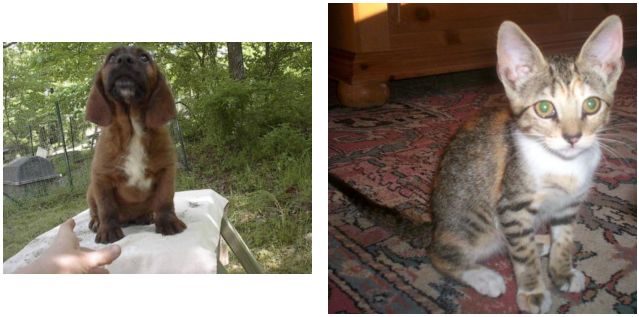

In [4]:
# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2)
#fig.suptitle("Training Data", fontsize=20)

img1 = data_dir + 'train/dog/5.jpg'
ax[0].axis('off')
ax[0].imshow(mpimg.imread(img1))

img2 = data_dir + 'train/cat/7.jpg'
ax[1].axis('off')
ax[1].imshow( mpimg.imread(img2))

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# function that accepts an image path and returns a format to be consumed by the model 
def process_img (img_path) : 
    transform_pipeline = transforms.Compose([transforms.Resize(img_size),
                                             transforms.ToTensor()])
    img = transform_pipeline(Image.open(img_path).convert("RGB")).to(device)
    return (img.unsqueeze(0))

In [7]:
from torchvision import models


torch.manual_seed(42)
np.random.seed(42)

# Assuming you have defined 'class_names' list containing the names of classes in your dataset.

# Load the pretrained ResNet18 model
model_conv = models.resnet18(pretrained=True)

# Freeze all the parameters in the pretrained model
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the fully connected layer to match the number of classes in your dataset
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names), bias=False)

# Set the parameters of the newly added fully connected layer to be trainable
for param in model_conv.fc.parameters():
    param.requires_grad = True

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
wd = 5e-4
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=wd)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.1)


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model_trained = train_model(model = model_conv, 
                         criterion = criterion, 
                         optimizer = optimizer_conv,
                         scheduler = exp_lr_scheduler, 
                         num_epochs = 6)

Epoch 0/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1867 Acc: 0.9259
val Loss: 0.0490 Acc: 0.9833

Epoch 1/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1488 Acc: 0.9399
val Loss: 0.0431 Acc: 0.9829

Epoch 2/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1509 Acc: 0.9435
val Loss: 0.0435 Acc: 0.9838

Epoch 3/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1389 Acc: 0.9453
val Loss: 0.0439 Acc: 0.9850

Epoch 4/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1081 Acc: 0.9573
val Loss: 0.0408 Acc: 0.9858

Epoch 5/5
----------


/home/dhruv.patel/anaconda3/envs/kiln/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1255 Acc: 0.9521
val Loss: 0.0431 Acc: 0.9838

Training complete in 1m 13s
Best val Acc: 0.985845


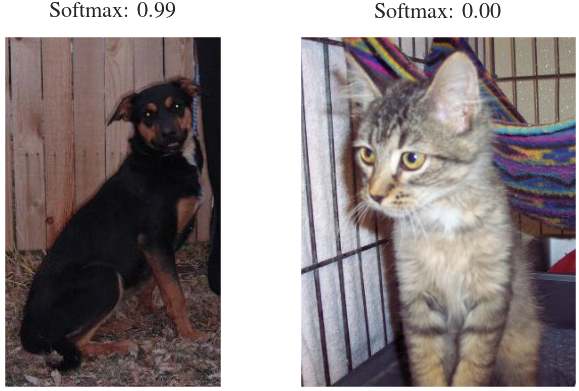

In [9]:
import matplotlib.pyplot as plt
from PIL import Image



# File paths of the two images
image_path_dog = '/home/dhruv.patel/pml/dog_cat/val/dog/18.jpg'
image_path_cat = '/home/dhruv.patel/pml/dog_cat/val/cat/2.jpg'


# Load the images
img_dog = Image.open(image_path_dog)
img_cat = Image.open(image_path_cat)


softmax_value_1 = softmax(model_trained(process_img('/home/dhruv.patel/pml/dog_cat/val/dog/18.jpg'))[0].cpu().detach().numpy())[1]
softmax_value_2 = softmax(model_trained(process_img('/home/dhruv.patel/pml/dog_cat/val/cat/2.jpg'))[0].cpu().detach().numpy())[1]


# Create the subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2)

# Plot the dog image with its softmax value as the title
axes[0].imshow(img_dog)
axes[0].set_title(f'Softmax: {softmax_value_1:.2f}')
axes[0].grid(False) 
axes[0].set_xticks([])  
axes[0].set_yticks([])

# Plot the cat image with its softmax value as the title
axes[1].imshow(img_cat)
axes[1].set_title(f'Softmax: {softmax_value_2:.2f}')
axes[1].grid(False) 
axes[1].set_xticks([])  
axes[1].set_yticks([])

plt.savefig('dog_cat_initial.pdf')

# Display the images
plt.show()


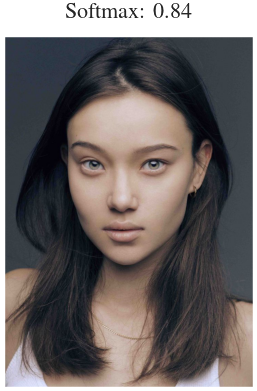

In [10]:
image_path_human = '/home/dhruv.patel/pml/humans/943.jpg'


# Load the images
img_human = Image.open(image_path_human)


softmax_value_3 = softmax(model_trained(process_img('/home/dhruv.patel/pml/humans/90.jpg'))[0].cpu().detach().numpy())[1]

# Plot the dog image with its softmax value as the title
plt.imshow(img_human)
plt.title(f'Softmax: {softmax_value_3:.2f}')
plt.grid(False) 
plt.xticks([])  
plt.yticks([])
# Display the images
plt.savefig('human_initial.pdf')
plt.show()

In [11]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

data_dir = "/home/dhruv.patel/pml/dog_cat"  # Replace with the actual path to your data directory
N_tr = 100
N_val = 1000

# Define the custom transformation to be applied to the images
custom_transform = transforms.Compose([
    transforms.Resize((32, 16)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

# Load the training data using torchvision's ImageFolder
train_dataset = ImageFolder(root=data_dir + '/train', transform=custom_transform)

# Load the validation data using torchvision's ImageFolder
val_dataset = ImageFolder(root=data_dir + '/val', transform=custom_transform)

# Select a subset of training data (N_tr samples) for x_train and y_train
x_train, y_train = torch.utils.data.random_split(train_dataset, [N_tr, len(train_dataset) - N_tr])

In [12]:
x_train

In [13]:
# Convert x_train into a tensor
x_train_tensor = torch.stack([x for x, _ in x_train])
y_train_tensor = torch.tensor(np.stack([y for _, y in x_train]))
y_train_tensor = y_train_tensor.reshape(N_tr,1)

In [14]:
x_train_tensor.shape

torch.Size([100, 1, 32, 16])

In [15]:
y_train_tensor.shape

torch.Size([100, 1])

In [16]:
tau_list = []
tau = 1.#./100. # 1/50 
for w in model_conv.fc.parameters():
#     print(w.nelement())
#     tau_list.append(tau/w.nelement())
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [17]:
len(tau_list)

1

In [18]:
# Define the shapes of the tensors
shape_1 = (100, 512)
shape_2 = (100, 2)

# Create random tensors with the specified shapes
tensor_1 = torch.randn(shape_1)
tensor_2 = torch.randn(shape_2)

In [19]:
import hamiltorch
hamiltorch.set_random_seed(0)
net = model_trained.fc
params_init = hamiltorch.util.flatten(net).to(device).clone()

step_size = 0.001#0.01# 0.003#0.002
num_samples = 1000#2000 # 3000
L = 10 #3  
tau_out = 1. 
normalizing_const = 1.
burn =0 #GPU: 3000

params_hmc = hamiltorch.sample_model(net, tensor_1, tensor_2, params_init=params_init, model_loss='binary_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:17 | 0d:00:00:00 | #################### | 1000/1000 | 55.68       
Acceptance Rate 1.00


In [20]:
probs_list = []
img = process_img('/home/dhruv.patel/pml/dog_cat/val/dog/18.jpg')
for i in params_hmc:
    part1 = torch.tensor(i[:512])  # Convert the slice to a tensor
    part2 = torch.tensor(i[512:])  # Convert the slice to a tensor
    model_trained.fc.weight = torch.nn.Parameter(torch.stack([part1, part2]))  # Stack the tensors into a single tensor
    probs = softmax(model_trained(img)[0].cpu().detach().numpy())
    probs_list.append(probs.data.tolist())



/tmp/ipykernel_1664915/287343978.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part1 = torch.tensor(i[:512])  # Convert the slice to a tensor
/tmp/ipykernel_1664915/287343978.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part2 = torch.tensor(i[512:])  # Convert the slice to a tensor


In [21]:
mean_softmax = np.mean(np.array(probs_list), axis = 0)
var_softmax = np.std(np.array(probs_list),axis =0)

In [22]:
mean_softmax

array([0.03075459, 0.96924541])

In [23]:
probs_list_human = []
img = process_img('/home/dhruv.patel/pml/humans/943.jpg')
for i in params_hmc:
    part1 = torch.tensor(i[:512])  # Convert the slice to a tensor
    part2 = torch.tensor(i[512:])  # Convert the slice to a tensor
    model_trained.fc.weight = torch.nn.Parameter(torch.stack([part1, part2]))  # Stack the tensors into a single tensor
    probs = softmax(model_trained(img)[0].cpu().detach().numpy())
    probs_list_human.append(probs.data.tolist())

/tmp/ipykernel_1664915/797427809.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part1 = torch.tensor(i[:512])  # Convert the slice to a tensor
/tmp/ipykernel_1664915/797427809.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part2 = torch.tensor(i[512:])  # Convert the slice to a tensor


In [24]:
mean_human_softmax = np.mean(np.array(probs_list_human), axis = 0)
var_human_softmax = np.std(np.array(probs_list_human),axis =0)

In [25]:
mean_human_softmax

array([0.29782588, 0.70217412])

In [26]:
var_human_softmax

array([0.26366593, 0.26366593])

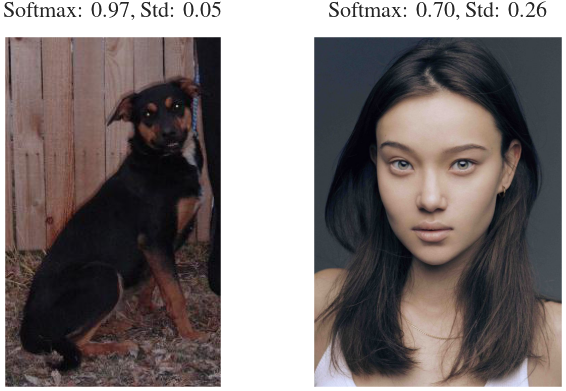

In [27]:
image_dog = '/home/dhruv.patel/pml/dog_cat/val/dog/18.jpg'
image_path_human = '/home/dhruv.patel/pml/humans/943.jpg'


# Load the images
img_dog = Image.open(image_dog)
img_human = Image.open(image_path_human)

fig, axes = plt.subplots(1, 2)

# Plot the dog image with its softmax value as the title
axes[0].imshow(img_dog)
axes[0].set_title(f'Softmax: {mean_softmax[1]:.2f}, Std: {var_softmax[1]:.2f}')
axes[0].grid(False) 
axes[0].set_xticks([])  
axes[0].set_yticks([])

axes[1].imshow(img_human)
axes[1].set_title(f'Softmax: {mean_human_softmax[1]:.2f}, Std: {var_human_softmax[1]:.2f}')
axes[1].grid(False) 
axes[1].set_xticks([])  
axes[1].set_yticks([])

# Display the images
plt.savefig('dog_human_hmc.pdf')
plt.show()